# Adaptive time stepping

In [166]:
# Load important libraries
import numpy as np
import matplotlib.pyplot as plt

### Basic RK4

We implement simple RK4 and its caller function.

In [167]:
# Basic Runge Kutta 4
def rk4(fn, x, y, h):
    k1 = h*fn(x, y)
    k2 = h*fn(x+h/2, y+k1/2)
    k3 = h*fn(x+h/2, y+k2/2)
    k4 = h*fn(x+h, y+k3)
    return y + (k1+2*k2+2*k3+k4)/6

# A caller function
def caller(my_method, fn, y_ini, x0, xT, h):
    # generate x values from x0 to xT 
    xs = np.arange(x0, xT, h)

    # calculate the number of steps
    N = len(xs)
    
    # initialize y
    y = y_ini
    
    # initialize storage to keep y values
    ys = np.zeros((N, len(y_ini)))
    
    # for each i
    for i in range(N):
        ys[i,:] = y              # store y
        x = xs[i]                # get x
        y = my_method(fn,x,y,h)  # update y
    
    # return all y
    return ys


### Apply on a simple ODE whose solution has a rapid change and a flat profile

The ODE function is $$ \frac{dy}{dx} = f(x,y) = -y $$

In [168]:
# for dy/dx = f(x,y)
# define f(x,y)
def f(x, y): 
    return -y

# Step size h
h = 0.2

# Time span 
x0 = 0.0
xT = 10.0

# Generate x values (for plotting and comparison)
xs = np.arange(x0, xT, h)
N = len(xs)

# Initialize y
y_ini = np.asarray([1.0])

# Final call: returns y values
ysrk4 = caller(rk4, f, y_ini, x0, xT, h)

### Plot the solution and also the error.

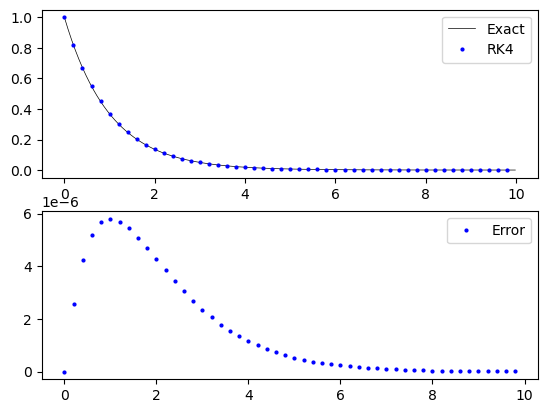

In [169]:
# Finely sampled solution for drawing a line
xfine = np.arange(x0, xT, h/10)
yfine = np.exp(-xfine)

# Also the exact solution
yexact = np.exp(-xs)

# Plot using subplots
plt.subplot(2,1,1)
plt.plot(xfine, yfine, 'k-',linewidth=0.5,label='Exact')
plt.plot(xs, ysrk4,'bo',markersize=2,label='RK4')
plt.legend()
plt.subplot(2,1,2)
yerror = [ysrk4[i][0] - yexact[i] for i in range(len(yexact))]
plt.plot(xs, yerror,'bo',markersize=2,label='Error')
plt.legend()

## Butcher tableau and RK methods

The Butcher tableau for a general $ s $-stage Runge-Kutta method is written as:

$$
\begin{array}{c|c}
a & B \\
\hline
 & c^T
\end{array}
$$

where:
+ $ a = (a_1, a_2, \dots, a_s) $ is the vector of node values (stage times).
+ $ B = (b_{ij}) $ is an $ s \times s $ matrix of coefficients that define the intermediate steps,
+ $ c = (c_1, c_2, \dots, c_s) $ is the weight vector,



### Summation Formulation

A general Runge-Kutta method computes the solution at $ t_{n+1} $ using intermediate stages:

$$
y_{n+1} = y_n + h \sum_{i=1}^{s} c_i k_i
$$

where the stage values $ k_i $ are computed as:

$$
k_i = f \left( t_n + a_i h, y_n + h \sum_{j=1}^{s} b_{ij} k_j \right), \quad i = 1, 2, \dots, s
$$

Here:
+ $ h $ is the step size,
+ $ f(t, y) $ represents the derivative function $ \frac{dy}{dt} $,
+ $ k_i $ are the intermediate function evaluations.


In [170]:
# Dormand-Prince in matrix form
a = [0.2, 0.3, 0.8, 8/9, 1.0, 1.0]
b = [
    [1/5, 0, 0, 0, 0, 0],
    [3/40, 9/40, 0, 0, 0, 0],
    [44/45, -56/15, 32/9, 0, 0, 0],
    [19372/6561, -25360/2187, 64448/6561, -212/729, 0, 0],
    [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656, 0],
    [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]
]
c = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]

# Dormand-Prince
a2 = 1/5;  b21 = 1/5;
a3 = 3/10; b31 = 3/40;       b32 = 9/40;
a4 = 4/5;  b41 = 44/45;      b42 = -56/15;      b43 = 32/9;
a5 = 8/9;  b51 = 19372/6561; b52 = -25360/2187; b53 = 64448/6561; b54 =-212/729;
a6 = 1;    b61 = 9017/3168;  b62 = -355/33;     b63 = 46732/5247; b64 = 49/176;  b65 = -5103/18656;
a7 = 1;    b71 = 35/384;     b72 = 0;           b73 = 500/1113;   b74 = 125/192; b75 = -2187/6784;  b76 = 11/84;

c1 = 35/384; c2 = 0; c3 = 500/1113; c4 = 125/192; c5=-2187/6784; c6 = 11/84; c7 = 0;
c1s = 5179/57600; c2s = 0; c3s = 7571/16695; c4s = 393/640; c5s = -92097/339200; c6s = 187/2100; c7s = 1/40;

### An implementation of 4th and 5th order embedded RK methods using Butcher tableau


In [171]:
# Embedded Runge-Kutta formulas
def erk54(f, x, y, h):
    k1 = h*f(x, y)
    k2 = h*f(x + a2*h, y + b21*k1)
    k3 = h*f(x + a3*h, y + b31*k1 + b32*k2)
    k4 = h*f(x + a4*h, y + b41*k1 + b42*k2 + b43*k3)
    k5 = h*f(x + a5*h, y + b51*k1 + b52*k2 + b53*k3 + b54*k4)
    k6 = h*f(x + a6*h, y + b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5)
    y5 = y + c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6       
    k7 = h*f(x + a7*h, y5)
    y4 = y + c1s*k1 + c2s*k2 + c3s*k3 + c4s*k4 + c5s*k5 + c6s*k6 + c7s*k7
    return y5, y4

# A caller function
def caller5(my_method, fn, y_ini, x0, xT, h):
    # x values uniformly sampled
    xs = np.arange(x0, xT, h)
    # number of points
    N = len(xs)
    # Initialize
    y = np.asarray(y_ini)
    # Initialize storage
    ys = np.zeros((N, len(y_ini)))
    # Loop over all xs
    for i in range(N):
        # store and ...
        ys[i,:] = y
        x = xs[i]
        # ... update
        y, y4 = my_method(fn,x,y,h)
    return ys


def caller4(my_method, fn, y_ini, x0, xT, h):
    # x values uniformly sampled
    xs = np.arange(x0, xT, h)
    # number of points
    N = len(xs)
    # Initialize
    y = np.asarray(y_ini)
    # Initialize storage
    ys = np.zeros((N, len(y_ini)))
    # Loop over all xs
    for i in range(N):
        # store and ...
        ys[i,:] = y
        x = xs[i]
        # ... update
        y5, y = my_method(fn,x,y,h)
    return ys

In [172]:
# Define the function
def f(x,y): 
    return -1.0*np.asarray(y)

# Initialize the parameters
max_iter = 500
abstol = 1.0e-6
reltol = 1.0e-6
y_ini = [1.0]
x0 = 0.0
xT = 10.0
h = 0.2
xs = np.arange(x0, xT, h)

# Caller functions provide the solutions
yserk5 = caller5(erk54, f, y_ini, x0, xT, h)
yserk4 = caller4(erk54, f, y_ini, x0, xT, h)

### plot solutions and errors

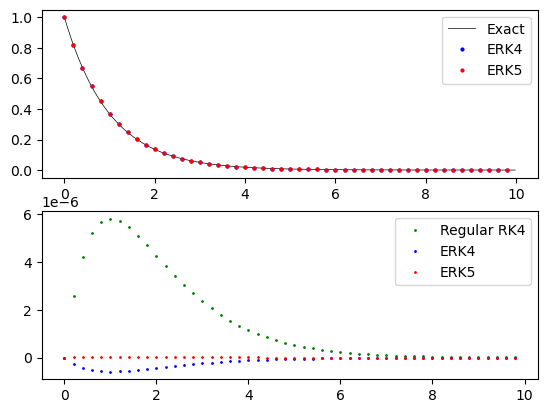

In [173]:
plt.subplot(2,1,1)
plt.plot(xfine, yfine, 'k-',linewidth=0.5,label='Exact')
plt.plot(xs, yserk4,'bo',markersize=2,label='ERK4')
plt.plot(xs, yserk5,'ro',markersize=2,label='ERK5')
plt.legend()

yerror4 = [yserk4[i][0] - yexact[i] for i in range(len(yexact))]
yerror5 = [yserk5[i][0] - yexact[i] for i in range(len(yexact))]
plt.subplot(2,1,2)
plt.plot(xs, yerror,'g.',markersize=2,label='Regular RK4')
plt.plot(xs, yerror4,'b.',markersize=2,label='ERK4')
plt.plot(xs, yerror5,'r.',markersize=2,label='ERK5')
plt.legend()

# **Predictor-Corrector Method for RK45**

The **Runge-Kutta-Fehlberg (RK45)** method is an **adaptive step-size** technique used for solving ordinary differential equations (ODEs). It employs a **predictor-corrector** approach using **two different Runge-Kutta formulas**—one of **4th-order** (predictor) and one of **5th-order** (corrector)—to estimate the error and adjust the step size dynamically.

---

## **Step-by-Step Description**

### **1. Predictor Step (4th-Order RK)**
We first compute an approximation $ y_{n+1}^{(4)} $ using the **4th-order Runge-Kutta** formula:

$$
y_{n+1}^{(4)} = y_n + h \sum_{i=1}^{6} b_i^{(4)} k_i
$$

where the intermediate function evaluations $ k_i $ are given by:

$$
k_i = f \left( t_n + c_i h, y_n + h \sum_{j=1}^{i-1} a_{ij} k_j \right)
$$

for $ i = 1, 2, \dots, 6 $.

### **2. Corrector Step (5th-Order RK)**
Next, we compute a more accurate approximation $ y_{n+1}^{(5)} $ using the **5th-order Runge-Kutta** formula:

$$
y_{n+1}^{(5)} = y_n + h \sum_{i=1}^{6} b_i^{(5)} k_i
$$

where the same $ k_i $ values are reused.

### **3. Error Estimation**
The local error estimate is obtained as the difference between the two approximations:

$$
E = y_{n+1}^{(5)} - y_{n+1}^{(4)}
$$

Since the 5th-order solution is more accurate, the error gives a measure of how much the 4th-order solution deviates.

### **4. Step Size Adjustment**
The step size $ h $ is adjusted based on the error $ E $:

$$
h_{\text{new}} = h_{\text{old}} \times \left( \frac{\epsilon}{|E|} \right)^{\frac{1}{5}}
$$

where $ \epsilon $ is the desired tolerance. If the error is too large, $ h $ is reduced; if it's small, $ h $ is increased to improve efficiency.


In [174]:
# Predictor-Corrector
# Embedded Runge-Kutta formulas
def erk54h(f, x, y, h, k7bh):
    # Implement FSAL (first same as last)
    # The first
    # k1 = k7bh, unless k1 is zero (initially)
    if sum(k7bh)==0: 
        k1 = h*f(x, y)
    else:
        k1 = k7bh*h

    # Implement rest of the Butcher table
    k2 = h*f(x + a2*h, y + b21*k1)
    k3 = h*f(x + a3*h, y + b31*k1 + b32*k2)
    k4 = h*f(x + a4*h, y + b41*k1 + b42*k2 + b43*k3)
    k5 = h*f(x + a5*h, y + b51*k1 + b52*k2 + b53*k3 + b54*k4)
    k6 = h*f(x + a6*h, y + b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5)

    # get y fifth-order correct
    y5 = y + c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6 # c7 = 0     
    
    # FSAL -> the last
    k7bh = f(x + a7*h, y5)

    #@printf("%.6f %.6f %.6f %.6f\n",x, y[1], y5[1], k7bh[1])

    # get y fourth-order correct
    y4 = y + c1s*k1 + c2s*k2 + c3s*k3 + c4s*k4 + c5s*k5 + c6s*k6 + c7s*k7bh*h

    # return y, error, k7bh
    err = abs(y5 - y4)
    return y5, err, k7bh

def caller54(fn, y_ini, x0, xT, h0, max_iter, abstol, reltol):
    y = np.asarray(y_ini); h = h0;
    ys = np.zeros((max_iter, len(y_ini)))
    xs = np.zeros((max_iter, 1))
    xs[0] = x0; ys[0,:] = y
    x = x0; i = 0; k = 1
    k7bh = np.zeros(len(y_ini))
    while x<=xT and i<max_iter:
        
        # calculate the tolerance
        if i == 0: 
            tol = abstol + reltol*np.linalg.norm(ys[i,:])
        else:
            tol = abstol + reltol*np.max([np.linalg.norm(ys[i,:]), np.linalg.norm(ys[i-1,:])])
        
        # get the next y and the error
        y, err, k7bh = erk54h(fn,xs[i],ys[i,:],h, k7bh)
        
        # get max error and the scale factor
        merr = np.max(err)
        #scale_factor = (tol/merr)^0.2
        
        # for debugging
        #print("%2d %.4f %.6f %.6f %g"%(i,xs[i],ys[i],h,merr))
        
        if merr == 0.0: 
            merr = tol/100

        # If the step is valid (less error than tol)
        # then we proceed
        if merr<tol:   
            x += h
            i += 1
            xs[i] = x
            ys[i,:] = y
            #k7 = k7t
            #print("%2d %.4f %.6f %.6f"%(i,xs[i],ys[i],k7[1]))
        
        # anyway we update h every time
        h = 0.9*h*(tol/merr)**0.2
    
    # if the maximum number of steps exceeded
    if i>=max_iter:
        println(i," Increase max_iter.")
        return None
    
    # return the usable portion of the array
    return xs[1:i-1], ys[1:i-1,:]


In [175]:
# Initialize parameters
max_iter = 2000
abstol = 1.0e-6
reltol = 1.0e-8
y_ini = [1.0]
x0 = 0.0
xT = 10.0
h0 = 0.2

# Final call 
xs54, yserk54 = caller54(f, y_ini, x0, xT, h0, max_iter, abstol, reltol)


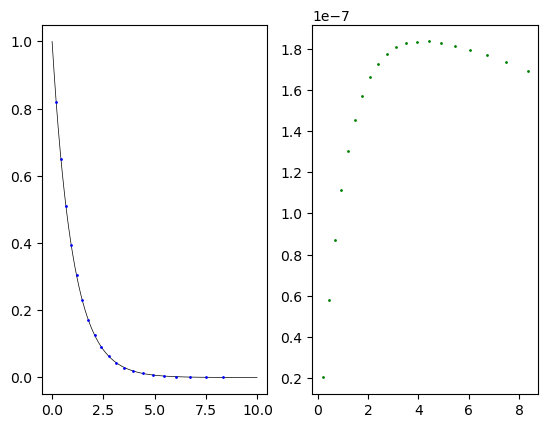

In [176]:
plt.subplot(1,2,1)
plt.plot(xfine, yfine, 'k-',linewidth=0.5)
plt.plot(xs54, yserk54, 'b.', markersize=2)

yexact = np.exp(-xs54)
error54 = [yserk54[i][0] - yexact[i] for i in range(len(xs54))]

plt.subplot(1,2,2)
plt.plot(xs54, error54,'g.',markersize=2)

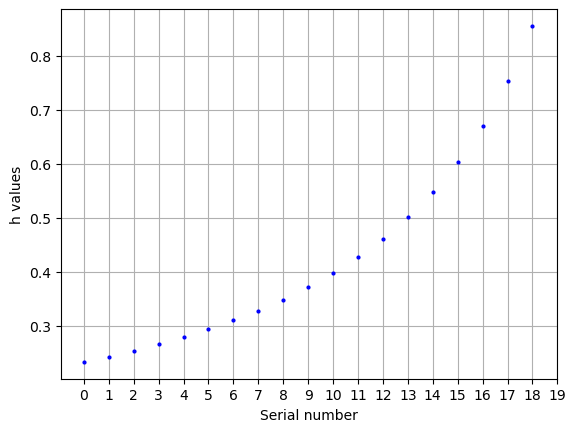

In [177]:
xs54l = [xs54[i][0] for i in range(len(xs54))]
plt.plot(np.diff(xs54l),'bo',markersize=2)
plt.xlabel('Serial number')
plt.ylabel('h values')
plt.xticks([i for i in range(20)])
plt.grid()